In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import os
import time
import praw


In [ ]:
reddit = praw.Reddit(client_id="gMMUyYPztGnIEw",
                     client_secret="BxzKaCmGcvlkxW7TmNnN4NIa6GI",
                     user_agent="Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36")
num_app= 0
num_hum= 1
num_disag= 2
num_ann= 3

In [2]:
def find(disType):
    if(disType== "elaboration"):
        return 0
    elif(disType== "agreement"):
        return 1
    elif(disType== "disagreement"):
        return 2
    elif(disType== "appreciation"):
        return 3
    
    return -1

In [3]:
def check_json():
    loc= '/home/bansal/Downloads/coarse_discourse_dataset.json'
    scores= []
    countdict= {}
    for comment in open(loc, 'r'):
        post= json.loads(comment)#nice
        for subpost in post['posts']:
            if('majority_type' in subpost):
                if(subpost['majority_type'] in countdict):
                    countdict[subpost['majority_type']]+= 1
                else:
                    countdict[subpost['majority_type']]= 1
    print (countdict)
    return countdict

In [ ]:
def read_json():
    counts= np.zeros(4)#appreciation, humor, question, announcement
    df= pd.read_csv('/home/bansal/Downloads/subreddits_basic.csv')
    with open('/home/bansal/Downloads/coarse_discourse_dataset.json') as jsonfile:
        lines = jsonfile.readlines()
        discoursedata = open('/home/bansal/Downloads/discourse_reddit_betterviralitycomments3.json', 'w')
        for line in lines:
            reader = json.loads(line)
            print(reader['url'])
            subreddit= reader['subreddit']
            subs= int(df.loc[df['reddit']== subreddit, 'subs'].values)
            submission = reddit.submission(url=reader['url'])
            submission.comment_sort = 'best'
            submission.comment_limit = 40
            post_dict= {}
            try:
                for post in reader['posts']:
#                     print ("GOTCHA:" + post['majority_type'])
                    if("majority_type" in post):
                        a= find(post['majority_type'])
                        if(a!= -1):
                            counts[a]+= 1
                            post_dict[post['id']]= post


                full_submission_id = 't3_' + submission.id
                if full_submission_id in post_dict:
#                     post_dict[full_submission_id]['body'] = submission.selftext
                    # For a self-post, this URL will be the same URL as the thread.
                    # For a link-post, this URL will be the link that the link-post is linking to.
                    post_dict[full_submission_id]['url'] = submission.url
#                     post_dict[full_submission_id]['virality']= abs(submission.ups) + abs(submission.downs) + len(reader['posts']) - 1
                    if submission.author:
                        post_dict[full_submission_id]['author'] = submission.author.name


                submission.comments.replace_more(limit=0)
                for comment in submission.comments.list():
                    full_comment_id = 't1_' + comment.id
                    if full_comment_id in post_dict:
                        post_dict[full_comment_id]['id']= full_comment_id
                        post_dict[full_comment_id]['body'] = comment.body
                        count= 0
                        for post in reader['posts']:
                            if('in_reply_to' in post and post['in_reply_to']== full_comment_id):
                                count+= 1
                        if(len(subs)> 0 and subs[0]!= 0):
                            post_dict[full_comment_id]['virality']= (abs(comment.ups) + abs(comment.downs) + count)/(subs[0])
                        if comment.author:
                            post_dict[full_comment_id]['author'] = comment.author.name
                            
            except Exception as e:
                print('Error %s' % (e))

            found_count = 0
            for post in reader['posts']:
                if not 'body' in post.keys():
                    print("Can't find %s in URL: %s" % (post['id'], reader['url']))
                else:
                    found_count += 1

            print('Found %s posts out of %s' % (found_count, len(reader['posts'])))

            discoursedata.write(json.dumps(reader) + '\n')
            time.sleep(2)



In [ ]:
def read_json2(filename):
    fullname= '/home/bansal/Downloads/' + filename + '.json'
    print (fullname)
    with open(fullname, 'r') as data_file:
        data= json.load(data_file)
        opfile= open('/home/bansal/Downloads/' + filename + 'op.json', 'w')
        count= 0
        for post in data:
            if(post['link_id']== post['parent_id']):
                post_dict= {}
                submission= reddit.submission(id= post['link_id'][3:])
                try:
                    post_dict['body']= submission.selftext
                    post_dict['url']= submission.url
                    print (submission.url)
                    post_dict['virality']= abs(submission.ups) + abs(submission.downs) + len(submission.comments)
                    post_dict['author']= submission.author.name
                    opfile.write(json.dumps(post_dict) + '\n')
                    count+= 1
                    print (count)
                    time.sleep(2)
                except Exception as e:
                    print(e)
        print ("The final count is: " + count)

{'answer': 41284, 'disagreement': 3430, 'question': 17635, 'announcement': 2002, 'elaboration': 19316, 'agreement': 5054, 'humor': 2420, 'appreciation': 8821, 'other': 2108, 'negativereaction': 1901}


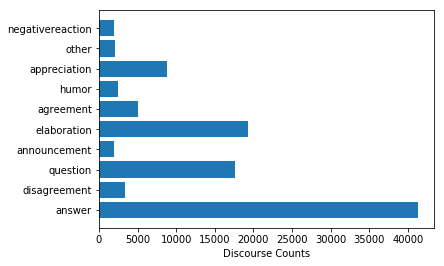

In [11]:
dictt= check_json()
plt.barh(range(len(dictt)), list(dictt.values()), align='center')
plt.yticks(range(len(dictt)), list(dictt.keys()))
plt.xlabel('Discourse Counts')
plt.show()